 # FitzHugh-Nagumo Type Models

In [1]:
%reset -f

from functools import partial
import numpy as np
import scipy.integrate
import scipy
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
import matplotlib.patches as mpatches #used to write custom legends
import sympy
import sympy.solvers.solvers as symsol
import numpy as np
from sympy import sympify, lambdify
import warnings
warnings.filterwarnings("ignore")
sympy.init_printing()
%matplotlib inline

## Define Dynamical System

In [2]:
def dvdt(v, w, a, b, c, d):
    return -w - abs( a + b * v ) * v
def dwdt(v, w, a, b, c, d):
    return ( 1 / c ) * ( v - d )

### Find Jacobian and derivatives using sympy

In [3]:
v, w = sympy.symbols("v, w", real=True)
a, b, c, d = sympy.symbols("a, b, c, d", real=True)

# Symbolic expression of the matrix
sys = sympy.Matrix([dvdt(v,w,a,b,c,d), dwdt(v,w,a,b,c,d)])
var = sympy.Matrix([v, w])
jac = sys.jacobian(var)

### Create Dynamical Functions

In [4]:
def fitzhugh_nagumo(x, t, a, b, c, d):
    return np.array([ eval("dvdt(x[0],x[1],a,b,c,d)") , 
                      eval("dwdt(x[0],x[1],a,b,c,d)") ])

def jacobian_fitznagumo(v, w, a, b, c, d):
    return np.array([[  -abs( a + b * v ) - v * b * np.sign( a + b * v )  , -1],
                       [1 / c, 0]])

def find_roots(a,b,c,d):
    yroot = d
    xroot = -abs( a + b * yroot )
    return [[yroot, xroot]]

### Draw the trajectories

In [5]:
# Define Parameter Values: d is the external forcing parameter
scenarios = [
    {"a":-4.7, "b":3.6, "c":1, "d":1.2},
    {"a":-4.7, "b":3.6, "c":1, "d":0.2},
    {"a":-4.7, "b":3.6, "c":1, "d":1.5}
]

In [6]:
def get_displacement(param, dmax=0.5,time_span=np.linspace(0,200, 1000)):
    ic = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                      y0=[0,0],
                                                      t= time_span)
    return [ic]

In [7]:
# Do the simulations.
time_span = np.linspace(0, 60, num=1500)
trajectories = {}
for i,param in enumerate(scenarios):
    trajectories[i] = get_displacement(param, time_span=time_span, dmax=5)

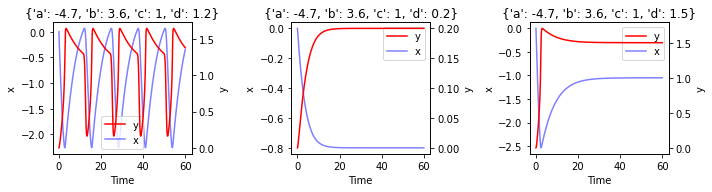

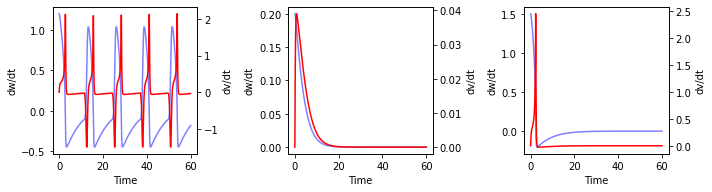

In [8]:
fig, ax = plt.subplots(1, len(scenarios), figsize=(5*len(scenarios)/1.5,5/1.8))

xyrange = {}
for i,param in enumerate(scenarios):
        ax_twin = ax[i].twinx()
        ax[i].set(xlabel='Time', ylabel='x',
                     title='{}'.format(param))
        ax_twin.set_ylabel('y')
        v = ax_twin.plot(time_span,trajectories[i][0][:,0], color='r')
        w = ax[i].plot(time_span,trajectories[i][0][:,1], color='b', alpha=.5)
        ax[i].legend([v[0],w[0]],['y','x'])
        xyrange[i]=[ax[i].get_ylim(),ax_twin.get_ylim()]
plt.tight_layout()
fig.savefig('figures/phase_figure.svg',
                    format='svg',bbox_inches='tight')

fig, ax = plt.subplots(1, len(scenarios), figsize=(5*len(scenarios)/1.5,5/1.8))
for i,param in enumerate(scenarios):
        ax_twin = ax[i].twinx()
        ax[i].set(xlabel='Time', ylabel='dw/dt')
        ax_twin.set_ylabel('dv/dt')
        va = trajectories[i][0][:,0]
        wa = trajectories[i][0][:,1]
        v = ax_twin.plot(time_span, -wa - va * abs( param["a"] + param["b"] * va ), color='r')
        w = ax[i].plot(time_span, -1 / param["c"] * ( va - param["d"] ), color='b', alpha=.5)
plt.tight_layout()

### Isocline and Vector Plots

In [9]:
def plot_isocline(ax, yrange, a, b, c, d, color='k', color2='r', style='-', opacity=0.8):
    v = np.linspace(yrange[0], yrange[1], 100)
    w_iso = -v * abs( a + b * v )
    ax.plot(w_iso, v, 'k-', label=r'$\frac{d v}{d t} = 0$')
    ax.hlines(d, w_iso.min(), w_iso.max(), color='k', ls='dashed', label=r'$\frac{d w}{d t} = 0$')
    ax.legend(loc='center right')
            
def plot_vector_field(ax, param, xrange, yrange, steps=50):
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    
    dy,dx = fitzhugh_nagumo([Y,X],0,**param)   
    
    ax.streamplot(X,Y,dx, dy, color=(0,0,0,.1))
    
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

### Equilibrium points

In [10]:
eqnproot = {}
for i, param in enumerate(scenarios):
    eqnproot[i] = find_roots(**param)

In [11]:
EQUILIBRIUM_COLOR = {'Stable node':'C0',
                    'Unstable node':'C1', 
                    'Saddle':'C4',
                    'Stable focus':'C3',
                    'Unstable focus':'C2',
                    'Center':'C5'}

In [12]:
def stability(jacobian):
    eigv = np.linalg.eigvals(jacobian)
        
    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        nature = "Center" 
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        nature = "Saddle"
    else: 
        stability = 'Unstable' if all(np.real(eigv)>0) else 'Stable'
        nature = stability + (' focus' if all(np.imag(eigv)!=0) else ' node')
    return nature

def stability_alt(jacobian):
    determinant = np.linalg.det(jacobian)
    trace = np.matrix.trace(jacobian)
    if np.isclose(trace, 0):
        nature = "Center (Hopf)"
    elif np.isclose(determinant, 0):
        nature = "Transcritical (Saddle-Node)"
    elif determinant < 0:
        nature = "Saddle"
    else:
        nature = "Stable" if trace < 0 else "Unstable"
        nature += " focus" if (trace**2 - 4 * determinant) < 0 else " node"
    return nature

In [13]:
eqstability = {}
for i, param in enumerate(scenarios):
    eqstability[i] = []
    for e in eqnproot[i]:
        J = jacobian_fitznagumo(e[0],e[1], **param)
        eqstability[i].append(stability(J))    

### Complete Phase Diagram

In [14]:
def plot_phase_diagram(a, b, c, d, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    ax.set(xlabel='w', ylabel='v')
    
    param={"a":a, "b":b, "c":c, "d":d}
        
    # Isocline and flow... 
    plot_vector_field(ax, param, xyrange[0][0], xyrange[0][1])
    plot_isocline(ax, xyrange[0][1], **param)

    # Nodes    
    v_nodes = np.array([-a / ( 2 * b ),
                        -a / b, 
                       ])
    w_nodes = -1 * v_nodes * abs( a + b * v_nodes )
    
    ax.scatter(w_nodes, v_nodes, zorder=4, marker='o', color='k')
    for n, txt in enumerate(['1','2']):
        ax.annotate(txt, (w_nodes[n], v_nodes[n]),zorder=4, fontsize=20)

    ax.set_xticks([])
    ax.set_yticks([])

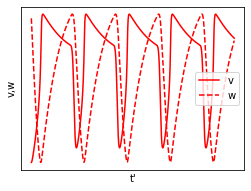

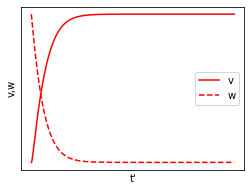

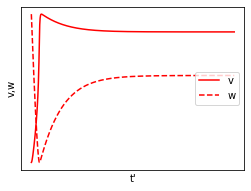

In [15]:
for i in range(len(scenarios)):
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.set(xlabel='t\'', ylabel='v,w')
    vi = trajectories[i][0][:,0]
    vi = (vi - np.min(vi))/np.ptp(vi)
    wi = trajectories[i][0][:,1]
    wi = (wi - np.min(wi))/np.ptp(wi)
    v = ax.plot(time_span,vi, color='r',label='v')
    w = ax.plot(time_span,wi, color='r',ls='dashed',label='w')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='center right')
    fig.savefig('figures/isocline_trajectory_'+str(i)+'.svg',
                        format='svg',bbox_inches='tight')

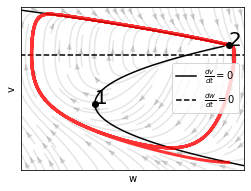

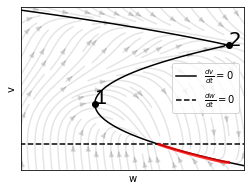

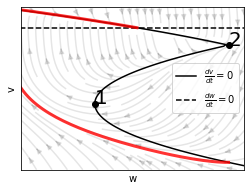

In [16]:
for i in range(len(scenarios)):
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    plot_phase_diagram(ax=ax, **scenarios[i])
    ax.plot(trajectories[i][0][:,1],trajectories[i][0][:,0],'r', lw=3, alpha=0.8)
    fig.savefig('figures/complete_phase_diagram_'+str(i)+'.svg',
                        format='svg',bbox_inches='tight')

# NGRIP O18 Record

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from scipy.optimize import curve_fit
import xarray as xr
from statsmodels.tsa.stattools import acf
import copy
from matplotlib.lines import Line2D
from matplotlib.transforms import Bbox
from matplotlib.ticker import MaxNLocator

# For AML
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK

In [18]:
event_number=[5.2,6,7]
age_offset = 1000
sav_width=301
sav_ord=3
proxy='Delta O18 (permil)'
tc = 500 / 3

## Import Data

In [19]:
 def import_raw_data():
    ngrip = pd.read_excel('./data/NGRIP_d18O_and_dust_5cm.xls',
                          header=0,sheet_name='NGRIP-2 d18O and Dust',
                          names=['NGRIP-2 depth (m)','Delta O18 (permil)',
                                 'Dust count (ml^-1)','age','MCE'],
                          index_col=3)
    ngrip = ngrip[~ngrip.index.duplicated(keep='first')].to_xarray()
    ngrip = ngrip.interp(age=np.arange(int(ngrip.age.min().values),
                                       int(ngrip.age.max().values+1),1))
    return ngrip
    

def import_stadial_data():
    sawtooth = pd.read_excel('./data/Lohmann_Ditlevsen_DO_events.xlsx',
                          header=0,
                          names=['event','stadialend','interstadialonset',
                                  'interstadialend','stadialonset','warmingrate','coolingrate'],
                          index_col=0).to_xarray()
    return sawtooth
    

def convert_O18_to_T(data):
    temperature=(data+24.8)/0.33 #https://en.wikipedia.org/wiki/Proxy_(climate)
    return temperature 

In [20]:
def plot_dansgaard_oeschger(data,stadial_data,event_number,plot_filter=True,
                            plot_event_numbers=True,ylabel=u'Shifted $\delta^{18}$O (‰)',
                            plot_temperature=False,second_plot=[], third_plot=[], ylim=[],fn='',
                            label=['Simulated', 'SavGol filter', 'Simulated',
                                   'd'],lw=2, title='NGRIP Ice Core Record',white_labels=False,
                           figsize=(8,3)):
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(111)    
    ax.tick_params(direction='in',top=True,right=True)
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Time B2K (kyr)')
    ax.invert_xaxis()
    
    if plot_filter==True:
        savgol_fit=savgol_filter(data,sav_width,sav_ord)
        ax.plot(data.age/1000,savgol_fit,'k',label=label[1],lw=2)
        ax.plot(data.age/1000,data,'k',label=label[0],alpha=0.5,lw=0.75)
    else:
        ax.plot(data.age/1000,data,'k',label=label[0],lw=lw)
        
    if len(second_plot)>1:
        ax.plot(second_plot.age/1000,second_plot,
                'b--',alpha=1,lw=2,label=label[2],zorder=3)
        
    if len(third_plot)>1:
        ax.plot(data.age/1000,third_plot,
                'k-.',alpha=1,lw=2,label=label[3])
    
    if plot_temperature==True:
        ax_right = ax.twinx()
        ax_right.plot(data.age/1000,convert_O18_to_T(data),
                      alpha=0)
        ax_right.set_ylabel('T ($^\circ$C)')
        ax_right.tick_params(direction='in')
        
    if len(ylim)>1:
        ax.set_ylim(ylim[0],ylim[1])
        
    if plot_event_numbers==True:
        for i in range(len(stadial_data['interstadialonset'])):
            ax.text(stadial_data['interstadialonset'][i]/1000,
                      plt.ylim()[1]-1.5,event_number[i],ha='right')
        
    if label != ['']:
        nrows = 3
        ncols = int(np.ceil(len(label) / float(nrows)))
        ax.legend(ncol=ncols, loc='lower center')

    ax.set_title(title)
    
    fig.savefig('figures/'+title+'.svg',
                    format='svg',bbox_inches='tight')
    
    if white_labels:
        ax.xaxis.label.set_color('w')
        ax.yaxis.label.set_color('w')
        ax.tick_params(axis='x', colors="w")
        ax.tick_params(axis='y', colors="w")
        ax.set_title(title,color='w')
        fig.savefig('figures/'+title+'_white.svg',
                format='svg',bbox_inches='tight')

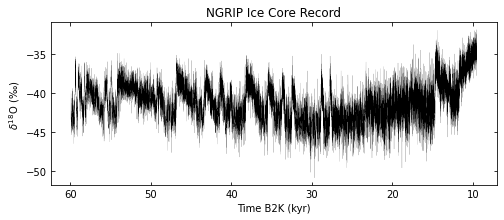

In [21]:
raw_data = import_raw_data()
stadial_data = import_stadial_data().sel(event=event_number)

plot_dansgaard_oeschger(raw_data[proxy], stadial_data, event_number,
                        plot_event_numbers=False, plot_filter=False,ylabel=u'$\delta^{18}$O (‰)', label=[''],lw=0.1)

# When plotting DO-events
mean_stadial = raw_data[proxy].where((raw_data.age>(stadial_data.stadialend.sel(event=6))) &
                (raw_data.age<(stadial_data.stadialonset.sel(event=7))),drop=True).mean()

ylim = [-6,8]
raw_data = raw_data.where((raw_data.age>(stadial_data.stadialonset.min()-age_offset)) &
                    (raw_data.age<(stadial_data.stadialend.max()+age_offset)),drop=True)

## Analyse Noise as AR(1) Function

In [22]:
# For saving axes instead of full figures
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.plot()
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    
    return bbox.expanded(1.0 + pad, 1.0 + pad)

def autocorrelation_function_1(a1, var_z, y0, t) :
    y = np.zeros(len(t))
    y[0] = y0
    for n,dt in enumerate(np.diff(t),1):
        y[n] = a1 * y[n-1] + np.random.normal(0,np.sqrt(var_z))
    return y

# Exponential function for the autocorrelation
def exponential_func(t, a):
    return np.exp( -a * t )


def plot_noise_subset(data,stadial_data,event_number
                      ,lw=0.01,nlags=10, nlagsfit=7):
    fig1=plt.figure(figsize=(4,3))
    ax1=fig1.add_subplot(111)
    fig2=plt.figure(figsize=(4,3))
    ax2=fig2.add_subplot(111)
    axs = {0:ax1,1:ax2}
        
    stadial_data = stadial_data.sel(event=event_number)
    w1 = stadial_data.sel(event=event_number[0]).stadialonset
    w2 = stadial_data.sel(event=event_number[0]).interstadialonset
    
    data = data.where((data.age>(stadial_data.stadialend.min())) &
                        (data.age<(stadial_data.stadialonset.max())),drop=True)
    
    # Determine alpha_1 values for ar(1) function
    acf_data = acf(data, nlags=nlags)
    a,_ = curve_fit(exponential_func, range(len(acf_data[:nlagsfit])), acf_data[:nlagsfit])
    a1_fit = np.exp(-a[0])
    
    stadial_shifted = data - data.mean()
    varx_data = ((stadial_shifted)**2).mean().values

    varz_fit = varx_data * ( 1 - a1_fit**2 )
                       
    y_generated_fit = autocorrelation_function_1(a1_fit, varz_fit, 0, data.age) + data.mean().values
    
    acf_generated_fit = acf(y_generated_fit, nlags=nlags)
    
    varx_fit = ((y_generated_fit - data.mean().values)**2).mean()
    
    label_data= (u'$\mu_\mathrm{s}$: '+str(np.round(mean_stadial.values,2))+
                 u'$\quad$Var$_\mathrm{s}$: '+ str(np.round(varx_data,2))
                 )
    label_fit = ('Var$_\mathrm{s}$: '+str(np.round(varx_fit,2))+
                 r'$\quad\sigma_{\mathrm{\varepsilon}}$: '+str(np.round(np.sqrt(varz_fit),2))
                )
    
    axs[0].plot(data.age/1000,data,'k',lw=1,label=label_data)
    axs[1].plot(data.age/1000,y_generated_fit,'k',lw=1,label=label_fit)
    axs[1].set_ylim(axs[0].get_ylim()[0],axs[0].get_ylim()[1])
    
    for i in axs:
        axs[i].tick_params(direction='in',top=True,right=True)
        axs[i].set_ylabel(u'$\delta^{18}$O (‰)')
        axs[i].set_xlabel('Time B2K (kyr)')
        axs[i].invert_xaxis()
        axs[i].legend(loc='upper right', handlelength=0)
        axs[i].hlines(mean_stadial,data.age.min()/1000,data.age.max()/1000,color='k', ls='dashed')

    fig1.savefig('figures/data_noise.svg',
                    format='svg', bbox_inches='tight')
    fig2.savefig('figures/simulated_noise.svg',
                    format='svg', bbox_inches='tight')
    
    # Plot autocorrelation functions in new figure
    fig=plt.figure(figsize=(4,3))
    ax=fig.add_subplot(111)    
    ax.tick_params(direction='in',top=True,right=True)
    
    ax.set(xlabel='Lag', ylabel='ACF')
    
    t = range(len(acf_data))
    ax.plot(t,np.exp( -a * t ),'k--', lw = 2, label=r'$\varphi^t$ fit: $t\leq$'+str(nlagsfit-1)+
            '\n'+r'$\varphi=$'+str(np.round(a1_fit,2)))
    ax.scatter(t,acf_data, color='k', label='NGRIP stadial')
    ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_yscale('log')
    fig.savefig('figures/autocorrelation.svg',
                format='svg',bbox_inches='tight')
        
    ax.scatter(t,acf_generated_fit, color='k', marker='x', label=(r'Simulated'))
    ax.legend()
    fig.savefig('figures/autocorrelation_simulated.svg',
                    format='svg',bbox_inches='tight')
    
    return varx_data, varz_fit, stadial_shifted

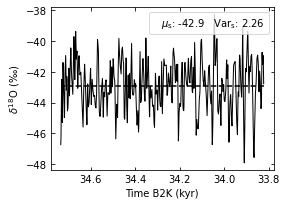

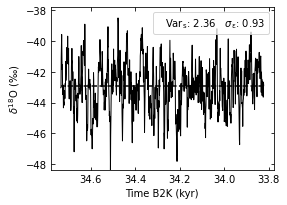

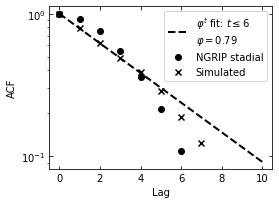

In [23]:
varx_data, varz_fit, stadial_shifted = plot_noise_subset(raw_data[proxy],stadial_data,event_number[1:])

# Combine Measurements and Model

In [24]:
# Define discrete stochastic dynamical functions
def euler_maruyama(flow, sigma_noise, y0, t) :
    y = np.zeros((len(t),len(y0)))
    y[0] = y0
    for n,dt in enumerate(np.diff(t),1):         
        y[n] = y[n-1] + flow(y[n-1],dt) * dt + np.sqrt(dt * tc) * np.random.normal(0,sigma_noise)
    return y

# Non-autonomous d(t)
def spiked_euler_maruyama(param, sigma_noise, y0, t, ta, tb, tsi, vmax, d_bc=0):
    y = np.zeros((len(t),len(y0)))
    d = np.zeros((len(t),1))
    y[0] = y0
    d[0] = 0
    param_temp = copy.deepcopy(param)
    for n,dt in enumerate(np.diff(t),1):
        param_temp['d'] = 0
        for i in range(len(ta)):
            # Slope d down
            if n >= tb[i] and n < tb[i]+d_bc:
                param_temp['d'] = d[n-1] - param['d'] / d_bc
            # Force d to value
            if n >= ta[i] and n < tb[i]:
                param_temp['d'] = copy.deepcopy(param['d'])
            # Force v,w to interstadial
            if n > (ta[i]-tsi[i]) and n <= ta[i]:    
                y[n-1] = np.vstack( ( vmax, -vmax * ( param['a'] + param['b'] * vmax ) ) )[:,i] + \
                np.sqrt(dt * tc) * np.random.normal(0,sigma_noise)
        flow = partial(fitzhugh_nagumo, **param_temp)
        y[n] = y[n-1] + flow(y[n-1],dt) * dt + np.sqrt(dt * tc) * np.random.normal(0,sigma_noise)
        d[n] = param_temp['d']
    return np.hstack((y,d))

### Find Optimal Parameters

In [25]:
# Define data used for optimization
## Number of data points to fit
n_fit = 120

## Autocorrelation from stadials
nlags = 5
autocor_data = acf(stadial_shifted, nlags=nlags)

In [26]:
def interstadial_fit(x, c0, c1, c2):
    return c0 - np.sqrt( c1 + c2 * x)

def extract_coefficients(data,stadial_data,event_numbers, tc, plot_fits=True):
    # What data to consider after t_max
    t_plot = np.arange(900)
    
    # Threshold to find collapse
    th = 0.3
    
    # Find maximum around interstadialonset
    max_range = 100
    
    # Change n_fit_func when a external forcing period is given
    try:
        n_fit_func = data.d_slope.values
    except:
        n_fit_func = n_fit
    if n_fit_func < n_fit:
        n_fit_func = n_fit
    
    event = stadial_data.sel(event=event_numbers)
    t_ib = np.array(event.interstadialonset.values)

    savgol_data = xr.DataArray(
        data = savgol_filter(data,sav_width,sav_ord),
        dims=["age"],
        coords=dict(
            age=(["age"], data.age)
        )
    )
    
    if plot_fits == True:
        fig=plt.figure(figsize=(8,3))
        ax=fig.add_subplot(111)    
        ax.tick_params(direction='in',top=True,right=True)

        ax.set_ylabel(u'Shifted $\delta^{18}$O (‰)')
        ax.set_xlabel('Time B2K (kyr)')
        ax.invert_xaxis()

        ax.plot(savgol_data.age/1000,savgol_data, 'k-') # Stopped shifting  + mean_stadial.values, 'k-')
            # Create custom legend
        legend_elements = [Line2D([0], [0], color='k', label='SavGol filter'),
                           Line2D([0], [0], marker='o', color='k', lw=0, label=r'Interstadial max ($v_\mathrm{max}$)'),
                           Line2D([0], [0], color='k', ls='dashed', alpha=0.5, label='Interstadial fit'),
                           Line2D([0], [0], marker='x', color='k', lw=0, label=r'Interstadial end ($v_\mathrm{end}$)')
                           ]
        ax.legend(handles=legend_elements, loc='lower center',ncol=2)

    v_max = np.zeros(len(event_numbers))
    t_max = np.zeros(len(event_numbers))
    v_end = np.zeros(len(event_numbers))
    t_end = np.zeros(len(event_numbers))
    sav_data = {}
    for i in range(len(event_numbers)):
        v_max[i] = savgol_data.interp(age=np.arange(t_ib[i]-max_range,t_ib[i]+max_range),
                                      method='nearest').max()
        t_max[i] = savgol_data.interp(age=np.arange(t_ib[i]-max_range,t_ib[i]+max_range),
                                      method='nearest').idxmax().values
        
        # Fit interstadial
        v_fit_data = savgol_data.interp(age=np.arange(t_max[i]-n_fit_func,t_max[i]),method='nearest')
        
        v_fit_coeffs,_ = curve_fit(lambda x, c1, c2: interstadial_fit(x, v_max[i], c1, c2), 
                                   np.arange(n_fit_func), np.flip( v_fit_data ).values,
                                   p0=[5e-8, 5e-3])
        # Analyze difference between fit and real SavGol fit
        v_stable = np.flip(interstadial_fit( t_plot, v_max[i], v_fit_coeffs[0], v_fit_coeffs[1]))
        v_ngrip = savgol_data.interp(age=np.arange(t_max[i]-len(t_plot),t_max[i]),method='nearest')
        v_dif = v_ngrip - v_stable      
        
        # Find first time where threshold condition is met
        t_end_nearly = v_dif.isel(age=150).age.values
        for n in reversed(v_dif):
            if n < -th:
                t_end_nearly = n.age.values
                break
                
        # Find first zero crossing after threshold
        t_zero = t_max[i]-t_plot[-1]
        for n in reversed(v_ngrip):
            if n < 0:
                t_zero = n.age.values
                break

        # Find last time where threshold condition is met
        for n in v_dif:
            if n > 0:
                t_end[i] = n.age.values
                break
        if t_end[i] > t_end_nearly or t_end[i] < t_zero:
            t_end[i] = t_end_nearly            
            
        v_end[i] = v_ngrip.sel(age=t_end[i])
        
        if plot_fits == True:
            # Fit
            ax.plot(v_ngrip.age/1000, v_stable, 'k--', alpha=0.5)
            
#             # t_end_nearly
#             ax.scatter(t_end_nearly/1000,v_ngrip.sel(age=t_end_nearly), 
#                         color='k', marker='X',alpha=0.5, s=100)
            
            # Final max and end
            ax.scatter(t_max[i]/1000, v_max[i], color='k')
            ax.scatter(t_end[i]/1000, v_end[i], color='k', marker='x')
    
        sav_data[event_numbers[i]] = v_fit_data
     
    if plot_fits == True:
        ax.set_ylim(ylim)
        for i in range(len(stadial_data['interstadialonset'])):
            ax.text(stadial_data['interstadialonset'][i]/1000,
                      plt.ylim()[1]-1.5,event_number[i],ha='right')
    
    return t_max, t_end, v_max, v_end, sav_data

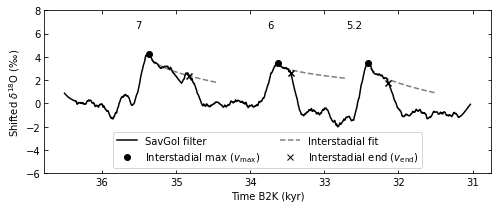

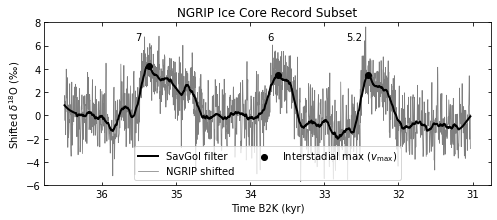

In [27]:
t_max_data, t_end_data, v_max_data, v_end_data, its_fit_data = extract_coefficients(raw_data[proxy]- mean_stadial,
                                                                             stadial_data, event_number, tc)
plt.savefig('figures/collapse_ngrip.svg',
                format='svg',bbox_inches='tight')

# Convert to index
stadial_ends_index = np.absolute(np.round(stadial_data.stadialend.values-raw_data.age.values[-1],0))
spike_dt_index = (stadial_data.stadialend.values - stadial_data.interstadialonset.values)
t_max_index = np.absolute(np.round(t_max_data-raw_data.age.values[-1],0))
t_end_index = np.absolute(np.round(t_end_data-raw_data.age.values[-1],0))

# Subset
plot_dansgaard_oeschger(raw_data[proxy]-mean_stadial,
                        stadial_data, event_number,label=['NGRIP shifted','SavGol filter'],
                        plot_event_numbers=True, ylim=ylim, title='NGRIP Ice Core Record Subset')
plt.scatter(t_max_data/1000, v_max_data, color='k',label=r'Interstadial max ($v_\mathrm{max}$)')
plt.legend(loc='lower center',ncol=2)
plt.savefig('figures/NGRIP Ice Core Record Subset Maxes.svg',format='svg',bbox_inches='tight')

#### Optimize a, b, c and d

In [28]:
def loss_function(flow_stadial, ic_stadial, stadial_time_span,
                  flow_interstadial, ic_interstadial, interstadial_time_simulation,
                  sigma_noise, varv_data, repeats):
    
    # Conditions to fill
    varv_simulated = np.zeros(repeats)
    dif_autocor = np.zeros(repeats)
    dif_interstadial = np.zeros((repeats,len(event_number)))
    var_stability = np.zeros(repeats)
    
    for i in np.arange(repeats):
        # Compare stadial
        stochastic_stadial = euler_maruyama(flow_stadial, sigma_noise,
                                            ic_stadial, stadial_time_span)[:,0]        
            ## Compare variance
        varv_simulated[i] = np.mean( stochastic_stadial**2 )
        
            ## Compare autocorrelation
        dif_autocor[i] = np.mean( acf(stochastic_stadial, nlags=nlags) - autocor_data )
        
        # Compare interstadial
        for eni in range(len(event_number)):
            simulated_interstadial = euler_maruyama(flow_interstadial, sigma_noise,
                                                ic_interstadial[:,eni], np.arange(n_fit) / tc)[:,0]
            ## Compare interstadial of events
            dif_interstadial[i,eni] = np.mean( simulated_interstadial -\
                                              np.flip( its_fit_data[event_number[eni]].values ) )
        
        # Check stability of spiked interstadial after 'interstadial_time_simulation'
        simulated_stability = euler_maruyama(flow_stadial, sigma_noise,
                                        ic_interstadial[:,0], interstadial_time_simulation)[:,0]
        var_stability[i] = np.mean( abs( simulated_stability[int(len( simulated_stability ) / 4 * 3):] ) )**2
    
    #1 Variance stadial (%)
    m1 = abs( np.mean( varv_simulated ) - varv_data ) / varv_data

    #2 Autocorrelation stadial (%)
    m2 = abs( np.mean( dif_autocor ) )
    
    #3 Difference interstadial savgol and simulated trajectory (%)
    m3 = abs( np.mean( dif_interstadial ) ) / np.array(list(its_fit_data.values())).mean()
    
    # 4 Stabilizes after bump
    m4 = abs( np.mean( var_stability ) - varv_data ) / varv_data
    return ( m1 * m2 * m3**3 * m4 )**( 1 / 7 ) * 100

def optimization_function(param_space):
    a, h, c, d = param_space['a'], param_space['h'], param_space['c'], param_space['d']
    
    # Simulated stadials
    param_stadial = {"a":a, "b":-a / h, "c":c, "d":0}
    flow_stadial = partial(fitzhugh_nagumo, **param_stadial)
    ic_stadial = [0,0]
    stadial_time_span = np.arange(1000) / tc
    
    # Simulate interstadials
    param_interstadial = {"a":a, "b":-a / h, "c":c, "d":d}
    flow_interstadial = partial(fitzhugh_nagumo, **param_interstadial)
    ic_interstadial = np.vstack( ( v_max_data, -v_max_data * ( a - a / h * v_max_data ) ) )
    interstadial_time_simulation = np.arange(1000) / tc
    
    sigma_noise = np.sqrt(varz_fit)
    varv_data = varx_data
    repeats = 5
    
    return {
        'loss': loss_function(flow_stadial, ic_stadial, stadial_time_span,
                              flow_interstadial, ic_interstadial, interstadial_time_simulation,
                              sigma_noise, varv_data, repeats),
        'status': STATUS_OK,
        'eval_time': time.time(),
        'attachments':
            {'time_module': pickle.dumps(time.time)}
        }

In [29]:
# # Run machine learning tool - uncomment to find new optimal parameters
# param_space = {
#     'a':hp.uniform('a', -35, -25),
#     'h':hp.uniform('h', 1.5, 2),  
#     'c':hp.uniform('c', 0.01, 0.05),
#     'd':hp.uniform('d', 1.5, 2.5),
# }

# optimized_param = fmin(optimization_function,
#                   space=param_space,
#                   algo=tpe.suggest,
#                   max_evals=500)
# best_param = {"a":optimized_param['a'], "b":-optimized_param['a'] / optimized_param['h'], 
#               "c":optimized_param['c'], "d":optimized_param['d']}
# print(best_param)

## Obtain tipping statistics

In [30]:
ic = [0,0]
time_span = raw_data[proxy].age / tc
d_slope = np.arange(0,800,10) # Set $\tau_\mathrm{d}$ value range

# # Results of previous runs
# {'a': -28.22386318920363, 'b': 16.245214392863126, 'c': 0.015392872704699107, 'd': 2.3618720562820825} 
# best loss: 0.5545589956800119

# best_param = {'a': -31.566593885356, 'b': 18.703547837667486, 'c': 0.035487552472291746, 'd': 1.0061875929851367}
# # best loss: 0.6716103386091221
    
# best_param = {'a': -30.38879670057991, 'b': 17.851870852854507, 'c': 0.0162259537176118, 'd': 2.217188673862267}
# best loss: 0.5988130676028562

# # New sigma
best_param = {'a': -28.757167950089, 'b': 16.670097141292562, 'c': 0.040676820097003456, 'd': 1.6919792644232987}
# best loss: 0.11357485933251531

# best_param = {'a': -27.055454608667514, 'b': 14.968319462417847, 'c': 0.038536232806140006, 'd': 1.639014292451989}
# best loss: 0.24111557309631956]

In [31]:
def generate_statistics(nr_repeats):
    # Generate trajectories and obtain \Delta t and \Delta v
    delta_t = np.zeros((len(event_number),len(d_slope),nr_repeats,2))
    delta_v = np.zeros((len(event_number),len(d_slope),nr_repeats,2))

    # Create empty dataset
    sim_stat_traj = xr.Dataset(
        data_vars=dict(
        ),
        coords=dict(
            age=("age", np.flip(time_span * tc)),
            variable=("variable", ["v","w","d"]),
            d_slope=("d_slope", d_slope)
        )
    )

    ## For loop too slow, improve in future
    for i in range(nr_repeats):
        # Generate data
        traj = np.zeros(tuple(sim_stat_traj.dims[d] for d in ['age', 'variable', 'd_slope']))
        for dsi in range(len(d_slope)):
            traj_temp = spiked_euler_maruyama(best_param, np.sqrt(varz_fit), ic, time_span,
                                         t_max_index, t_max_index+d_slope[dsi],
                                         abs(stadial_ends_index-t_max_index),
                                         v_max_data, 0)
            traj[:,:,dsi] = traj_temp
        sim_stat_traj['bnd'] =(['age', 'variable','d_slope'], traj)

        # Extract tipping points
        for dsi in range(len(d_slope)):
            try:
                t_max, t_end, v_max, v_end, _ = extract_coefficients(sim_stat_traj['bnd'].\
                                                                     sel(variable='v').\
                                                                     isel(d_slope=dsi),
                                                                     stadial_data, event_number, 
                                                                     tc, plot_fits=False)
                delta_t[:,dsi,i,0] = t_max-t_end
                delta_v[:,dsi,i,0] = v_max-v_end
            except:
                print('repeat '+str(i)+' failed to fit')
                delta_t[:,dsi,i,0] = delta_t[:,dsi,i-1,0]
                delta_v[:,dsi,i,0] = delta_v[:,dsi,i-1,0]
        print(str(int( ( i + 1 ) / ( nr_repeats ) * 100 ))+'% ', end = '')
    
    # Calculate without noise
    print('Calculating without noise...')
    traj = np.zeros(tuple(sim_stat_traj.dims[d] for d in ['age', 'variable', 'd_slope']))
    for dsi in range(len(d_slope)):
        traj_temp = spiked_euler_maruyama(best_param, 0, ic, time_span,
                                     t_max_index, t_max_index+d_slope[dsi],
                                     abs(stadial_ends_index-t_max_index),
                                     v_max_data, 0)
        traj[:,:,dsi] = traj_temp
    sim_stat_traj['bd'] =(['age', 'variable','d_slope'], traj)

    # Extract coefficients
    for dsi in range(len(d_slope)):
        try:
            t_max, t_end, v_max, v_end, _ = extract_coefficients(sim_stat_traj['bd'].\
                                                                 sel(variable='v').\
                                                                 isel(d_slope=dsi),
                                                                 stadial_data, event_number, 
                                                                 tc, plot_fits=False)
            for i in range(nr_repeats):
                delta_t[:,dsi,i,1] = t_max-t_end
                delta_v[:,dsi,i,1] = v_max-v_end
        except:
            print('forcing time '+str(d_slope[dsi])+'kyr failed to fit')
            for i in range(nr_repeats):
                delta_t[:,dsi,i,1] = delta_t[:,dsi-1,i,1]
                delta_v[:,dsi,i,1] = delta_v[:,dsi-1,i,1]

    # Create statistics dataset
    statistics = xr.Dataset(
        data_vars=dict(
            delta_t=(["int_nr","d_slope","repeat","noise"], delta_t),
            delta_v=(["int_nr","d_slope","repeat","noise"], delta_v),
            delta_t_real = (["int_nr"], t_max_data - t_end_data ),
            delta_v_real = (["int_nr"], v_max_data - v_end_data ),
        ),
        coords=dict(
            int_nr=("int_nr", event_number),
            d_slope=("d_slope", d_slope),
            repeat=("repeat", np.arange(nr_repeats)),
            noise=("noise", ['On','Off'])
        )
    )
    
    # Save dataset
    statistics.to_netcdf("data/statistics.nc")

In [32]:
# # Uncomment to generate new statistics
# generate_statistics(25)

In [33]:
# Import dataset
statistics = xr.open_dataset("data/statistics.nc")

In [34]:
# Time error
statistics['dif_time'] = statistics['delta_t']# / statistics['delta_t_real']  - 1
statistics['mean_dif_time'] = statistics['dif_time'].mean(dim=['repeat','int_nr'])
statistics['var_dif_time'] = abs(statistics['dif_time'] - statistics['dif_time'].mean(dim=['repeat']) )\
                                .mean(dim=['repeat','int_nr'])

# 18O error
statistics['dif_18O'] = -statistics['delta_v']# / statistics['delta_v_real'] - 1
statistics['mean_dif_18O'] = statistics['dif_18O'].mean(dim=['repeat','int_nr'])
statistics['var_dif_18O'] = abs(statistics['dif_18O'] - statistics['dif_18O'].mean(dim=['repeat']) )\
                                .mean(dim=['repeat','int_nr'])

In [35]:
# Cut off data for plots
d_max = 800
statistics = statistics.where(statistics.d_slope<=d_max, drop=True)

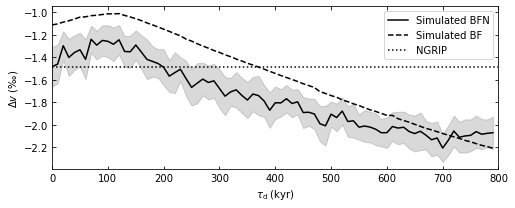

In [36]:
# Plot statistics
fig=plt.figure(figsize=(8,3))
ax=fig.add_subplot(111)    
ax.tick_params(direction='in',top=True,right=True)
ax.set(xlabel=r'$\tau_\mathrm{d}$ (kyr)', ylabel=r'$\Delta v$ (‰)')

#BND 18O
ax.plot(statistics.d_slope, statistics['mean_dif_18O'].sel(noise='On'),color='k', 
        label='Simulated BFN', zorder=3)
# BD 18O
ax.plot(statistics.d_slope, statistics['mean_dif_18O'].sel(noise='Off'),color='k', 
        label='Simulated BF', ls='dashed', zorder=3)

# Plot error bars
ax.fill_between(statistics.d_slope,
                 statistics['mean_dif_18O'].sel(noise='On')-statistics['var_dif_18O'].sel(noise='On')/2,
                 statistics['mean_dif_18O'].sel(noise='On')+statistics['var_dif_18O'].sel(noise='On')/2,
                alpha=0.15, color='k')

# Plot 0 line
ax.plot(np.arange(d_max),np.arange(d_max)*0-np.mean(statistics['delta_v_real']).values,'k-',
        label='NGRIP',ls='dotted')
ax.set_xlim(0,d_max)

ax.legend(loc='upper right')

# ax.scatter(d_opt, 0, color='k', marker='|', s=100000, alpha = 0.5)
# ax.annotate(xy=(d_opt, ax.get_ylim()[1]+0.01), text=r'Optimal $\tau_\mathrm{d}$: '+'\n'+str(int(d_opt))+' kyr', ha='center', 
#             va='bottom', annotation_clip=False)

fig.savefig('figures/optimize_d_v.svg',
                format='svg',bbox_inches='tight')

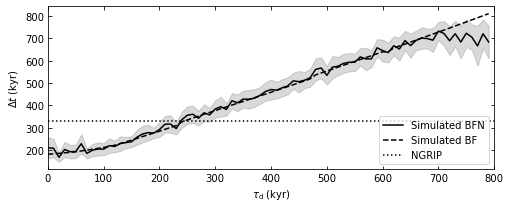

In [37]:
# Plot statistics
fig=plt.figure(figsize=(8,3))
ax=fig.add_subplot(111)    
ax.tick_params(direction='in',top=True,right=True)
ax.set(xlabel=r'$\tau_\mathrm{d}$ (kyr)', ylabel=r'$\Delta t$ (kyr)')

# BND Time
ax.plot(statistics.d_slope, statistics['mean_dif_time'].sel(noise='On'),color='k', 
        label='Simulated BFN', zorder=3)

# BD Time
ax.plot(statistics.d_slope, statistics['mean_dif_time'].sel(noise='Off'),color='k', 
        label='Simulated BF', ls='dashed', zorder=3)

# Plot error bars
ax.fill_between(statistics.d_slope,
                 statistics['mean_dif_time'].sel(noise='On')-statistics['var_dif_time'].sel(noise='On')/2,
                 statistics['mean_dif_time'].sel(noise='On')+statistics['var_dif_time'].sel(noise='On')/2,
                alpha=0.15, color='k')

# Plot NGRIP line
ax.plot(np.arange(d_max),np.arange(d_max)*0+np.mean(statistics['delta_t_real']).values,'k-'
        ,label='NGRIP',ls='dotted')
ax.set_xlim(0,d_max)

ax.legend(loc='lower right')

fig.savefig('figures/optimize_d_t.svg',
                format='svg',bbox_inches='tight')

In [38]:
# Determine optimal d
d_opt = abs(
    abs(statistics['mean_dif_18O'].sel(noise='On')-
        statistics['delta_v_real'].mean(dim='int_nr')
       )+
    abs(statistics['mean_dif_time'].sel(noise='On')-
        statistics['delta_t_real'].mean(dim='int_nr')
       )
).idxmin().values
print(d_opt)

240.0


## Plot Visual Difference

In [42]:
b = spiked_euler_maruyama(best_param, 0, ic, time_span,
                             t_max_index, t_max_index,
                             abs(stadial_ends_index-t_max_index),
                             v_max_data, 0)
bn = spiked_euler_maruyama(best_param, np.sqrt(varz_fit), ic, time_span,
                             t_max_index, t_max_index,
                             abs(stadial_ends_index-t_max_index),
                             v_max_data, 0)
bd = spiked_euler_maruyama(best_param, 0, ic, time_span,
                             t_max_index, t_max_index+d_opt,
                             abs(stadial_ends_index-t_max_index),
                             v_max_data, 0)
bnd = spiked_euler_maruyama(best_param, np.sqrt(varz_fit), ic, time_span,
                             t_max_index, t_max_index+d_opt,
                             abs(stadial_ends_index-t_max_index),
                             v_max_data, 0)

best_param_d0 = copy.deepcopy(best_param)
best_param_d0['d'] = 0
bn_nospike = euler_maruyama(partial(fitzhugh_nagumo, **best_param_d0), np.sqrt(varz_fit), ic, time_span)
b_nospike = euler_maruyama(partial(fitzhugh_nagumo, **best_param_d0), 0, ic, time_span)
bn_nospike = np.column_stack((bn_nospike,np.zeros(len(time_span))))
b_nospike = np.column_stack((b_nospike,np.zeros(len(time_span))))

bnd_nospike = euler_maruyama(partial(fitzhugh_nagumo, **best_param), np.sqrt(varz_fit), ic, time_span)
bd_nospike = euler_maruyama(partial(fitzhugh_nagumo, **best_param), 0, ic, time_span)
bnd_nospike = np.column_stack((bnd_nospike,np.ones(len(time_span))*best_param['d']))
bd_nospike = np.column_stack((bd_nospike,np.ones(len(time_span))*best_param['d']))

                       
trajectories_regimes = xr.Dataset(
    data_vars=dict(
        b=(['age','variable'], b),
        bn=(['age','variable'], bn),
        bd=(['age','variable'], bd),
        bnd=(['age','variable'], bnd),
        bn_nospike=(['age','variable'], bn_nospike),
        b_nospike=(['age','variable'], b_nospike),
        bnd_nospike=(['age','variable'], bnd_nospike),
        bd_nospike=(['age','variable'], bd_nospike)
    ),
    coords=dict(
        age=("age", np.flip(time_span * tc)),
        variable=("variable", ["v","w","d"]),
    )
)

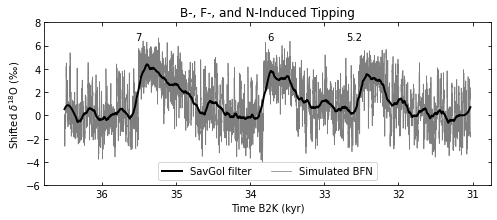

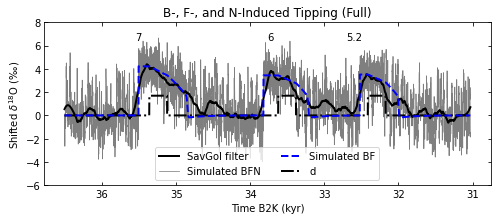

In [43]:
# Plot optimized model
plot_dansgaard_oeschger((trajectories_regimes['bnd'].sel(variable='v')),
                        stadial_data, event_number,
#                         second_plot=trajectories_regimes['bd'].sel(variable='v'),
#                         third_plot=(trajectories_regimes['bnd'].sel(variable='d')),
                        label=['Simulated BFN','SavGol filter','Simulated BF','d'],
                        plot_event_numbers=True, ylim=ylim, title='B-, F-, and N-Induced Tipping')

# Plot optimized model with trajectories
plot_dansgaard_oeschger((trajectories_regimes['bnd'].sel(variable='v')),
                        stadial_data, event_number,
                        second_plot=trajectories_regimes['bd'].sel(variable='v'),
                        third_plot=(trajectories_regimes['bnd'].sel(variable='d')),
                        label=['Simulated BFN','SavGol filter','Simulated BF','d'],
                        plot_event_numbers=True, ylim=ylim, title='B-, F-, and N-Induced Tipping (Full)')

# Additional Figures

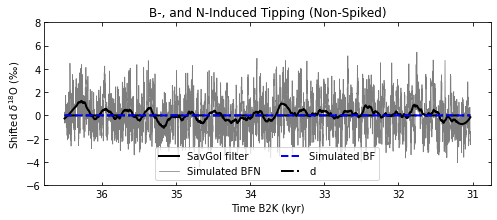

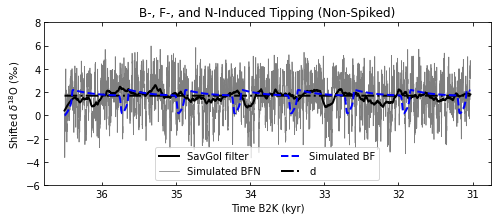

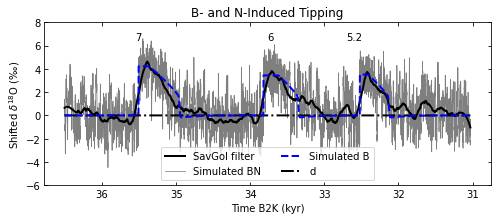

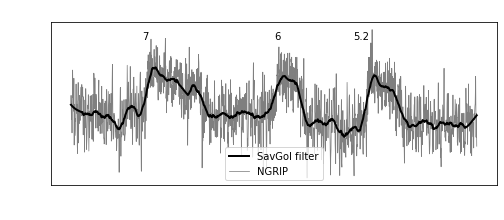

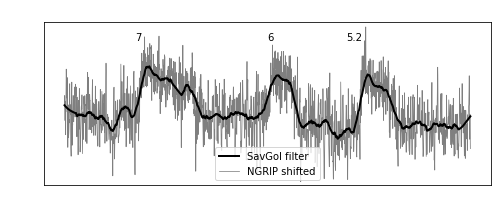

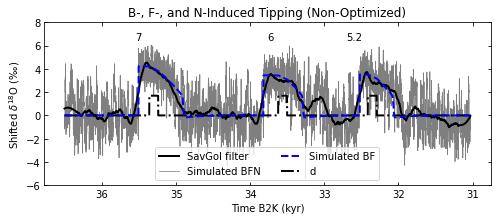

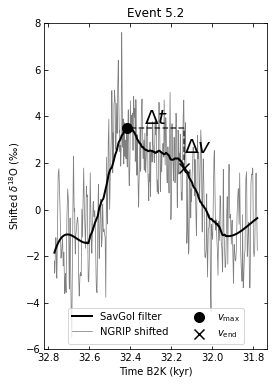

In [41]:
# Without spiking
plot_dansgaard_oeschger(trajectories_regimes['bn_nospike'].sel(variable='v'),
                        stadial_data, event_number,
                        second_plot=trajectories_regimes['b_nospike'].sel(variable='v'),
                        third_plot=trajectories_regimes['bn_nospike'].sel(variable='d'),
                        label=['Simulated BFN','SavGol filter','Simulated BF','d'],
                        plot_event_numbers=False, ylim=ylim, title='B-, and N-Induced Tipping (Non-Spiked)')
plot_dansgaard_oeschger(trajectories_regimes['bnd_nospike'].sel(variable='v'),
                        stadial_data, event_number,
                        second_plot=trajectories_regimes['bd_nospike'].sel(variable='v'),
                        third_plot=trajectories_regimes['bnd_nospike'].sel(variable='d'),
                        label=['Simulated BFN','SavGol filter','Simulated BF','d'],
                        plot_event_numbers=False, ylim=ylim, title='B-, F-, and N-Induced Tipping (Non-Spiked)')

# Only bifurcation induced
plot_dansgaard_oeschger((trajectories_regimes['bn'].sel(variable='v')),
                        stadial_data, event_number,
                        second_plot=trajectories_regimes['b'].sel(variable='v'),
                        third_plot=(trajectories_regimes['bn'].sel(variable='d')),
                        label=['Simulated BN','SavGol filter','Simulated B','d'],
                        plot_event_numbers=True, ylim=ylim, title='B- and N-Induced Tipping')

# White images
plot_dansgaard_oeschger(raw_data[proxy],
                        stadial_data, event_number,label=['NGRIP','SavGol filter'],ylabel=u'$\delta^{18}$O (‰)',
                        plot_event_numbers=True, title='NGRIP Ice Core Record Subset',white_labels=True)

plot_dansgaard_oeschger(raw_data[proxy]-mean_stadial,
                        stadial_data, event_number,label=['NGRIP shifted','SavGol filter'],
                        plot_event_numbers=True, ylim=ylim, title='NGRIP Ice Core Record Subset (Shifted)',white_labels=True)

# Non optimal d
bnd_no = spiked_euler_maruyama(best_param, np.sqrt(varz_fit), ic, time_span,
                             t_max_index, t_max_index+120,
                             abs(stadial_ends_index-t_max_index),
                             v_max_data, 0)
bd_no = spiked_euler_maruyama(best_param, 0, ic, time_span,
                             t_max_index, t_max_index+120,
                             abs(stadial_ends_index-t_max_index),
                             v_max_data, 0)
                       
non_optimized_traj = xr.Dataset(
    data_vars=dict(
        bnd_no=(['age','variable'], bnd_no),
        bd_no=(['age','variable'], bd_no)
    ),
    coords=dict(
        age=("age", np.flip(time_span * tc)),
        variable=("variable", ["v","w","d"]),
    )
)
plot_dansgaard_oeschger((non_optimized_traj['bnd_no'].sel(variable='v')),
                        stadial_data, event_number,
                        second_plot=non_optimized_traj['bd_no'].sel(variable='v'),
                        third_plot=non_optimized_traj['bnd_no'].sel(variable='d'),
                        label=['Simulated BFN','SavGol filter','Simulated BF','d'],
                        plot_event_numbers=True, ylim=ylim, title='B-, F-, and N-Induced Tipping (Non-Optimized)')

# dv dt explaination figure
stadial_data_52 = import_stadial_data().sel(event=5.2)
raw_data_52 = raw_data.where((raw_data.age>(stadial_data_52.stadialonset.min()-age_offset/4)) &
                    (raw_data.age<(stadial_data_52.stadialend.max()+age_offset/4)),drop=True)
plot_dansgaard_oeschger(raw_data_52[proxy]-mean_stadial,
                        stadial_data, event_number[-1],label=['NGRIP shifted','SavGol filter'],
                        plot_event_numbers=False, ylim=ylim, title='Event 5.2', figsize=(4,6))
plt.scatter(t_max_data[0]/1000, v_max_data[0], color='k',label=r'$v_\mathrm{max}$',s=100)
plt.scatter(t_end_data[0]/1000, v_end_data[0], color='k', marker='x', label=r'$v_\mathrm{end}$',s=100)
plt.plot(np.linspace(t_end_data[0]/1000,t_max_data[0]/1000,10),np.ones(10)*v_max_data[0], 'k--', alpha=0.75)
plt.text((t_end_data[0]+t_max_data[0])/2000,v_max_data[0],r'$\Delta t$',ha='center',va='bottom',size=20)
plt.plot(np.ones(10)*t_end_data[0]/1000,np.linspace(v_end_data[0],v_max_data[0],10), 'k--', alpha=0.75)
plt.text(t_end_data[0]/1000,(v_end_data[0]+v_max_data[0])/2,r'$\Delta v$',ha='left',va='center',size=20)
plt.legend(loc='lower center',ncol=2)
plt.savefig('figures/event52_dvdt.svg',
                format='svg',bbox_inches='tight')